<a href="https://colab.research.google.com/github/sushirito/Methylmercury/blob/main/PHREEQC_PaperReplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install phreeqpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 10.6 MB/s eta 0:00:00


In [ ]:
import urllib.request
import phreeqpy.iphreeqc.phreeqc_dll as phreeqc_mod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants and Configuration
CAP_THICKNESS = 1.0  # meters
NUM_CELLS = 100
CELL_LENGTH = CAP_THICKNESS / NUM_CELLS
POROSITY = 0.4
DIFFUSION_COEFFICIENT = 3e-10  # m^2/s
HYDRAULIC_CONDUCTIVITY = 1e-6  # m/s
ADVECTIVE_FLOW_RATE = 0.1 / (365 * 24 * 3600)  # m/year converted to m/s
SIMULATION_TIME = 50 * 365 * 24 * 3600  # 50 years in seconds
TIME_STEP = 365 * 24 * 3600  # 1 year in seconds
SHIFTS = SIMULATION_TIME // TIME_STEP

In [ ]:
# Download the IPhreeqc Library and database
urllib.request.urlretrieve('https://github.com/rispr/phreeqc_web/blob/main/Iphreeqc_compiled/libiphreeqc-3.7.3.so?raw=true', 'libiphreeqc.dll')
lib = '/content/libiphreeqc.dll'

import os

def get_database(dbName):
    urllib.request.urlretrieve('https://raw.githubusercontent.com/rispr/phreeqc_web/main/database/' + dbName, dbName)
    dbase = '/content/' + dbName
    if os.path.exists(dbase):
        print(f"Database file {dbase} exists.")
        with open(dbase, 'r') as f:
            print("First 100 characters of the database file:")
            print(f.read(100))
    else:
        print(f"Database file {dbase} does not exist.")
    return dbase

def run_phreeqc_simulation(lib, dbase, pqc_input):
    try:
        phreeqc = phreeqc_mod.IPhreeqc(lib)
        print(f"IPhreeqc object created successfully. Library: {lib}")
    except Exception as e:
        print(f"Error creating IPhreeqc object: {str(e)}")
        raise

    try:
        result = phreeqc.load_database(dbase)
        print(f"Database loaded. Result: {result}. Database: {dbase}")
        print("Database components:")
        i = 0
        while True:
            try:
                component = phreeqc.get_component(i)
                print(f"Component {i}: {component}")
                i += 1
            except IndexError:
                break
    except Exception as e:
        print(f"Error loading database: {str(e)}")
        raise

    try:
        result = phreeqc.run_string(pqc_input)
        print(f"Run string result: {result}")
    except Exception as e:
        print(f"Error running simulation: {str(e)}")
        raise

    phreeqc.set_output_file_on()
    return phreeqc
# Download and get the path for the database
dbase = get_database('phreeqc.dat')

# Initialize PHREEQC
iphreeqc = phreeqc_mod.IPhreeqc(lib)
iphreeqc.load_database(dbase)

def get_phreeqc_components():
    return lib, dbase

Database file /content/phreeqc.dat exists.
First 100 characters of the database file:
# PHREEQC.DAT for calculating pressure dependence of reactions, with
#   molal volumina of aqueous s


In [ ]:
def create_solution_block(solution_number, conditions):
    return f"""
SOLUTION {solution_number}
    units mol/kgw
    temp 25
    pH {conditions['pH']}
    pe {conditions['pe']}
    As {conditions['As']}
    Hg {conditions['Hg']}
    C {conditions['C']}
    Ca {conditions['Ca']}
    Cl {conditions['Cl']}
    Fe {conditions['Fe']}
    N {conditions['N']}
    Na {conditions['Na']}
    S {conditions['S']}
    Si {conditions['Si']}
    -water 1 # kg
"""

def create_transport_block():
    return f"""
TRANSPORT
    -cells                 {NUM_CELLS}
    -lengths               {CELL_LENGTH}
    -time_step             {TIME_STEP}
    -shifts                {SHIFTS}
    -diffusion_coefficient {DIFFUSION_COEFFICIENT}
    -dispersivities        0
    -correct_disp          true
    -multi_d               true
    -interlayer_d          false
    -porosities            {POROSITY}
    -print_frequency       1
    -punch_frequency       1
    -boundary_conditions   flux flux
"""

def create_kinetics_block():
    # This is a placeholder. You need to implement the kinetic reactions from Table 4.
    return """
KINETICS 1-100
    # Add kinetic reactions here
RATES
    # Add rate expressions here
"""

In [ ]:
def create_phreeqc_input():
    initial_conditions = {
        "pH": 8.0, "pe": 12.6,
        "As": 0.000126, "Hg": 5.01e-8, "C": 0.000794,
        "Ca": 0.01, "Cl": 0.1, "Fe": 0.000000501,
        "N": 0.00001, "Na": 0.1, "S": 0.01, "Si": 0.0001
    }

    lower_boundary = {
        "pH": 7.0, "pe": -2.5,
        "As": 0.000126, "Hg": 5.01e-8, "C": 0.0000316,
        "Ca": 0.00025, "Cl": 0.001, "Fe": 0.00000251,
        "N": 1e-8, "Na": 0.000501, "S": 0.00001, "Si": 0.0001
    }

    phreeqc_input = create_solution_block(0, initial_conditions)  # Upper boundary
    phreeqc_input += create_solution_block("1-100", initial_conditions)  # Initial porewater
    phreeqc_input += create_solution_block(101, lower_boundary)  # Lower boundary
    phreeqc_input += create_transport_block()
    phreeqc_input += create_kinetics_block()
    phreeqc_input += """
SELECTED_OUTPUT
    -file                  cap_simulation.csv
    -reset                 false
    -solution              true
    -distance              true
    -time                  true
    -pH                    true
    -pe                    true
    -alkalinity            true
    -ionic_strength        true
    -water                 true
    -charge_balance        true
    -percent_error         true
    -totals                As Hg Fe S Si
    -molalities            As(3) As(5) Hg(OH)2 HgS2-2 FeOH2+ Fe+2 HS- SO4-2 H4SiO4
    -equilibrium_phases    Goethite Mackinawite Pyrite Realgar Orpiment HgS
"""
    return phreeqc_input

In [ ]:
def run_simulation(lib, dbase):
    phreeqc_input = create_phreeqc_input()
    phreeqc = run_phreeqc_simulation(lib, dbase, phreeqc_input)
    results = phreeqc.get_selected_output_array()
    df = pd.DataFrame(results[1:], columns=results[0])
    print("Columns in the results DataFrame:", df.columns)
    print("Unique time values:", df['time'].unique())
    print("Shape of results DataFrame:", df.shape)
    return df

def plot_results(df, species):
    plt.figure(figsize=(10, 6))
    distance_col = 'dist_x'
    species_col = f'{species}(mol/kgw)'

    if distance_col not in df.columns or species_col not in df.columns:
        print(f"Error: Required columns ('{distance_col}' and/or '{species_col}') not found in the DataFrame.")
        print("Available columns:", df.columns)
        return

    for year in [0, 10, 20, 30, 40, 50]:
        year_data = df[df['time'] == year * 365 * 24 * 3600]
        if not year_data.empty:
            # Filter out zero or negative values for log scale
            valid_data = year_data[(year_data[distance_col] > 0) & (year_data[species_col] > 0)]
            if not valid_data.empty:
                plt.plot(valid_data[distance_col], valid_data[species_col], label=f'Year {year}')
            else:
                print(f"No valid positive data for Year {year}")
        else:
            print(f"No data for Year {year}")

    plt.xlabel('Distance (m)')
    plt.ylabel(f'{species} concentration (mol/kgw)')
    plt.title(f'{species} concentration profile over time - Advection scenario')
    plt.legend()

    # Only use log scale if there are positive values
    if df[species_col].max() > 0:
        plt.yscale('log')
    else:
        print(f"Warning: No positive values for {species}, using linear scale")

    plt.show()

    # Print some statistics about the data
    print(f"\nStatistics for {species}:")
    print(df[species_col].describe())

PHREEQC components retrieved. Lib: /content/libiphreeqc.dll, Database: /content/phreeqc.dat
IPhreeqc object created successfully. Library: /content/libiphreeqc.dll
Database loaded. Result: None. Database: /content/phreeqc.dat
Database components:
Run string result: None


Columns in the results DataFrame: Index(['soln', 'dist_x', 'time', 'pH', 'pe', 'Alk(eq/kgw)', 'mu', 'mass_H2O',
       'charge(eq)', 'pct_err', 'As(mol/kgw)', 'Hg(mol/kgw)', 'Fe(mol/kgw)',
       'S(mol/kgw)', 'Si(mol/kgw)', 'm_As(3)(mol/kgw)', 'm_As(5)(mol/kgw)',
       'm_Hg(OH)2(mol/kgw)', 'm_HgS2-2(mol/kgw)', 'm_FeOH2+(mol/kgw)',
       'm_Fe+2(mol/kgw)', 'm_HS-(mol/kgw)', 'm_SO4-2(mol/kgw)',
       'm_H4SiO4(mol/kgw)', 'Goethite', 'd_Goethite', 'Mackinawite',
       'd_Mackinawite', 'Pyrite', 'd_Pyrite', 'Realgar', 'd_Realgar',
       'Orpiment', 'd_Orpiment', 'HgS', 'd_HgS'],
      dtype='object')
Unique time values: [-9.900000e+01  1.000000e+00  0.000000e+00  3.153600e+07  6.307200e+07
  9.460800e+07  1.261440e+08  1.576800e+08  1.892160e+08  2.207520e+08
  2.522880e+08  2.838240e+08  3.153600e+08  3.468960e+08  3.784320e+08
  4.099680e+08  4.415040e+08  4.730400e+08  5.045760e+08  5.361120e+08
  5.676480e+08  5.991840e+08  6.307200e+08  6.622560e+08  6.937920e+08
  7.253280e+08

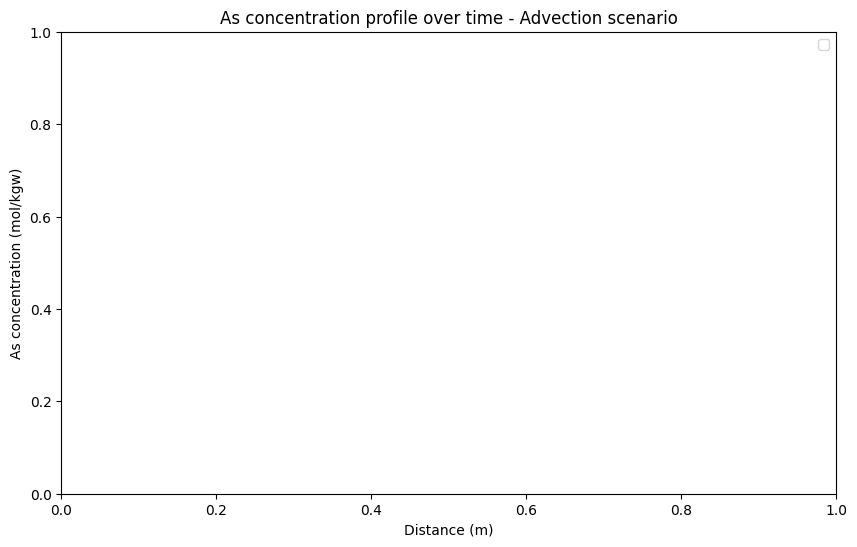


Statistics for As:
count    5206.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: As(mol/kgw), dtype: float64
No valid positive data for Year 0
No valid positive data for Year 10
No data for Year 20
No data for Year 30
No valid positive data for Year 40
No valid positive data for Year 50


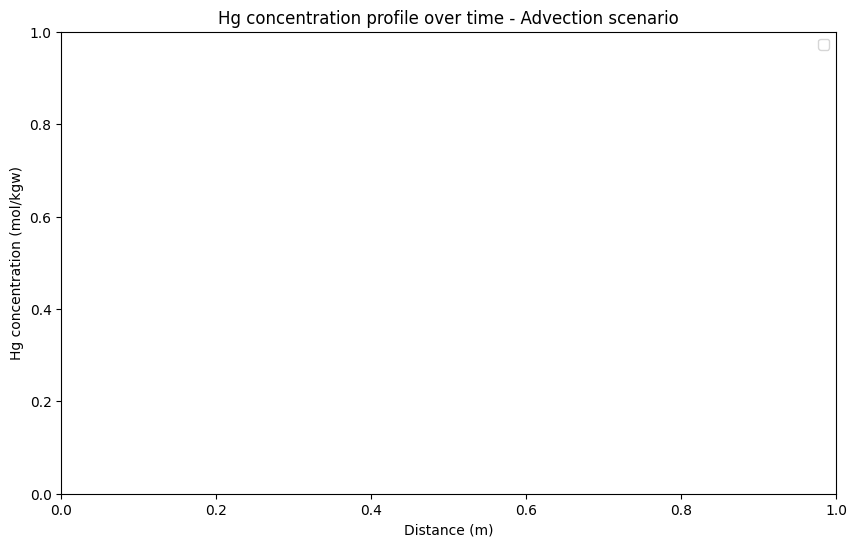


Statistics for Hg:
count    5206.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Hg(mol/kgw), dtype: float64


In [ ]:
def main():
    try:
        lib, dbase = get_phreeqc_components()
        print(f"PHREEQC components retrieved. Lib: {lib}, Database: {dbase}")
        results = run_simulation(lib, dbase)
        print("First few rows of the results DataFrame:")
        print(results.head())
        plot_results(results, 'As')
        plot_results(results, 'Hg')
    except Exception as e:
        print(f"An error occurred in main: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()